<a href="https://colab.research.google.com/github/keripikkaneboo/Machine-Learning/blob/main/Week2/CitarumWater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             2500 non-null   int64  
 1   NamaSungai     2500 non-null   object 
 2   TitikPantau    2500 non-null   object 
 3   Waktu          2500 non-null   object 
 4   pH             2500 non-null   float64
 5   Temp           2500 non-null   object 
 6   TSS            2500 non-null   float64
 7   DO             2500 non-null   float64
 8   BOD            2500 non-null   float64
 9   COD            2500 non-null   float64
 10  Nitrat         2500 non-null   float64
 11  FecalColiform  2500 non-null   float64
 12  Fosfat         2500 non-null   float64
 13  O2             2500 non-null   object 
 14  IP             2500 non-null   float64
 15  Class          2500 non-null   int64  
dtypes: float64(9), int64(2), object(5)
memory usage: 312.6+ KB
None

Contoh Data:

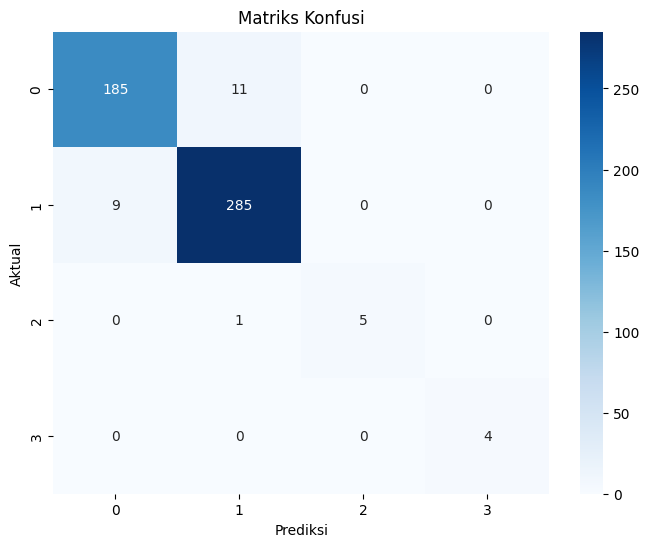

Tidak dapat menampilkan feature importance


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            precision_score, recall_score, f1_score, roc_auc_score,
                            roc_curve, auc)
import seaborn as sns

# Memuat dataset
url = "https://raw.githubusercontent.com/keripikkaneboo/Machine-Learning/main/Week2/CitarumWater.csv"
data = pd.read_csv(url)

# Melihat informasi dataset
print("Informasi Dataset:")
print(data.info())
print("\nContoh Data:")
print(data.head())

# Mengidentifikasi kolom numerik dan kategorikal
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nKolom Kategorikal:", categorical_cols)
print("Kolom Numerik:", numeric_cols)

# Jika kolom target termasuk dalam kolom kategorikal, kita perlu memisahkannya
target_column = data.columns[-1]  # Asumsikan kolom terakhir adalah target
features = data.drop(columns=[target_column])
target = data[target_column]

# Update kolom kategorikal dan numerik setelah memisahkan target
categorical_cols = [col for col in categorical_cols if col != target_column]
numeric_cols = [col for col in numeric_cols if col != target_column]

# Membuat pipeline preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Buat pipeline lengkap dengan model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Melatih model
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # Probabilitas untuk ROC dan AUC

# Jika target bukan numerik, konversi ke numerik untuk evaluasi
if target.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_pred_encoded = label_encoder.transform(y_pred)
    print("\nKelas Target:", label_encoder.classes_)

    # Evaluasi model
    print("\n===== EVALUASI MODEL =====")
    print("\nAkurasi:", accuracy_score(y_test, y_pred))
    print("Presisi:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))

    # Menghitung AUC-ROC untuk kasus multi-class dengan pendekatan OvR (One-vs-Rest)
    if len(label_encoder.classes_) == 2:
        # Kasus biner
        # Ambil probabilitas untuk kelas positif (kelas kedua dalam urutan label_encoder)
        y_pred_proba_pos = y_pred_proba[:, 1]
        roc_auc = roc_auc_score(y_test_encoded, y_pred_proba_pos)
        print("AUC-ROC:", roc_auc)

        # Menampilkan ROC Curve
        fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba_pos)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        # Kasus multi-class: One-vs-Rest approach
        n_classes = len(label_encoder.classes_)

        # Menghitung dan menampilkan AUC untuk setiap kelas
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            # Untuk setiap kelas, hitung ROC curve dan AUC
            fpr[i], tpr[i], _ = roc_curve((y_test_encoded == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and AUC
        fpr["micro"], tpr["micro"], _ = roc_curve(np.eye(n_classes)[y_test_encoded].ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(10, 8))

        # Plot micro-average and macro-average ROC curves
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
                color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
                color='navy', linestyle=':', linewidth=4)

        # Plot ROC curves for all classes
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                    label=f'ROC curve of class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve untuk Semua Kelas')
        plt.legend(loc="lower right")
        plt.show()

        # Menampilkan nilai AUC untuk setiap kelas
        print("\nAUC-ROC per kelas:")
        for i in range(n_classes):
            print(f"Kelas {label_encoder.classes_[i]}: {roc_auc[i]:.3f}")
        print(f"Micro-average AUC: {roc_auc['micro']:.3f}")
        print(f"Macro-average AUC: {roc_auc['macro']:.3f}")

    # Laporan klasifikasi rinci
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred))

    # Visualisasi matriks konfusi
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Matriks Konfusi')
    plt.show()
else:
    # Evaluasi model untuk kasus target numerik
    print("\n===== EVALUASI MODEL =====")
    print("\nAkurasi:", accuracy_score(y_test, y_pred))
    print("Presisi:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))

    # ROC dan AUC untuk target numerik jika biner
    if len(np.unique(y_test)) == 2:
        # Mencari indeks kelas positif
        pos_idx = 1 if 1 in np.unique(y_test) else np.unique(y_test)[1]

        # Hitung ROC dan AUC
        y_pred_proba_pos = y_pred_proba[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba_pos)
        print("AUC-ROC:", roc_auc)

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_pos)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    # Laporan klasifikasi rinci
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred))

    # Visualisasi matriks konfusi
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Matriks Konfusi')
    plt.show()

# Mencoba mendapatkan feature importance jika memungkinkan
try:
    # Ambil koefisien dari model logistik
    classifier = model.named_steps['classifier']
    preprocessor = model.named_steps['preprocessor']

    # Mendapatkan nama fitur setelah preprocessing
    if len(categorical_cols) > 0:
        cat_encoder = preprocessor.named_transformers_['cat']
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
    else:
        cat_feature_names = []

    transformed_feature_names = list(numeric_cols) + list(cat_feature_names)

    # Visualisasi koefisien
    coef = pd.DataFrame(
        classifier.coef_.T,
        index=transformed_feature_names,
        columns=['Koefisien']
    )

    plt.figure(figsize=(10, 8))
    coef = coef.sort_values('Koefisien', ascending=False)
    sns.barplot(x='Koefisien', y=coef.index, data=coef)
    plt.title('Pentingnya Fitur dalam Model Klasifikasi Logistik')
    plt.tight_layout()
    plt.show()
except:
    print("Tidak dapat menampilkan feature importance")

Berikut penjelasan untuk semua persamaan matematika yang digunakan dalam evaluasi model klasifikasi logistik:

## 1. Akurasi (Accuracy)
**Rumus**: $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

**Penjelasan**: Akurasi mengukur proporsi prediksi yang benar dibandingkan dengan jumlah total prediksi. Ini dihitung dengan membagi jumlah prediksi benar (True Positive + True Negative) dengan jumlah total prediksi.

## 2. Presisi (Precision)
**Rumus**: $\text{Precision} = \frac{TP}{TP + FP}$

**Penjelasan**: Presisi mengukur proporsi hasil positif yang diidentifikasi dengan benar dibandingkan dengan semua hasil positif yang diprediksi. Ini mengukur seberapa "tepat" model dalam memprediksi kelas positif.

## 3. Recall (Sensitivitas)
**Rumus**: $\text{Recall} = \frac{TP}{TP + FN}$

**Penjelasan**: Recall mengukur proporsi hasil positif aktual yang diidentifikasi dengan benar. Ini mengukur kemampuan model untuk menemukan semua contoh positif.

## 4. F1-Score
**Rumus**: $\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

**Penjelasan**: F1-Score adalah rata-rata harmonik dari presisi dan recall. Ini memberikan keseimbangan antara presisi dan recall, yang penting ketika distribusi kelas tidak seimbang.

## 5. ROC (Receiver Operating Characteristic)
**Penjelasan**: ROC adalah grafik yang menunjukkan kinerja klasifikasi model pada semua ambang batas klasifikasi. Grafik ini dibuat dengan memplot:
- True Positive Rate (TPR) atau Recall: $TPR = \frac{TP}{TP + FN}$
- False Positive Rate (FPR): $FPR = \frac{FP}{FP + TN}$

## 6. AUC (Area Under the ROC Curve)
**Rumus**: AUC = ∫ ROC Curve

**Penjelasan**: AUC mengukur seluruh area dua dimensi di bawah kurva ROC. Ini dapat diinterpretasikan sebagai probabilitas bahwa model akan memberi peringkat contoh positif acak lebih tinggi daripada contoh negatif acak. Nilai berkisar dari 0 hingga 1, dengan 0.5 mewakili model acak dan 1 mewakili model sempurna.

## 7. Multi-class ROC dan AUC
Untuk kasus multi-kelas, kita menggunakan pendekatan "One-vs-Rest" (OvR):

**Micro-average AUC**:
- Menggabungkan hasil dari semua kelas dan kemudian menghitung metrik secara keseluruhan.
- $\text{AUC}_{\text{micro}} = \text{AUC}\left( \bigcup_{i=1}^{n} y_i, \bigcup_{i=1}^{n} \hat{p}_i \right)$

**Macro-average AUC**:
- Menghitung metrik untuk setiap kelas secara individual dan kemudian mengambil rata-rata.
- $\text{AUC}_{\text{macro}} = \frac{1}{n} \sum_{i=1}^{n} \text{AUC}_i$

## 8. Regresi Logistik
**Rumus**: $P(y=1|x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}}$

**Penjelasan**: Dalam regresi logistik, kita menggunakan fungsi logistik (sigmoid) untuk memodelkan probabilitas bahwa suatu instance termasuk dalam kelas positif. Koefisien βᵢ menunjukkan pentingnya fitur xᵢ dalam memprediksi hasil.

## 9. Matriks Konfusi
Matriks konfusi menampilkan empat nilai utama:
- True Positive (TP): Kasus positif yang diprediksi dengan benar
- False Positive (FP): Kasus negatif yang salah diprediksi sebagai positif
- True Negative (TN): Kasus negatif yang diprediksi dengan benar
- False Negative (FN): Kasus positif yang salah diprediksi sebagai negatif

Untuk kasus multi-kelas, matriks konfusi berukuran n×n, di mana n adalah jumlah kelas.

## 10. Weighted Average untuk Metrics Multi-kelas
Saat menggunakan `average='weighted'` dalam fungsi scikit-learn:

**Rumus**: $\text{Metric}_{\text{weighted}} = \sum_{i=1}^{n} w_i \times \text{Metric}_i$

**Penjelasan**: Metrik (presisi, recall, F1) dihitung untuk setiap kelas dan kemudian dirata-ratakan dengan pembobotan sesuai dengan jumlah instance sebenarnya di kelas tersebut, di mana wᵢ adalah proporsi instances dari kelas i.

Semua metrik evaluasi ini bekerja sama untuk memberikan gambaran komprehensif tentang kinerja model klasifikasi logistik Anda.